# Khai báo thư viện

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import datetime
import seaborn as sns
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

%matplotlib inline

# Xử lý dữ liệu

Nếu thu thập 00:00:00 1/1/2023 đến ngày 00:00:00 1/12/2025 thì sẽ được 25,561  dòng dữ liệu, nhưng trong tập 2 tập dữ liệu thu thập ở trên thì:
- Tâp air_quality.csv có 22,504 dữ liệu  - thiếu 3,059 dữ liệu
- Tập weather_hourly.csv có 22,368 dữ liệu - thiếu  3,193 dữ liệu

In [ ]:

# Load dữ liệu 
df_air = pd.read_csv('data/air_quality.csv')
df_weather = pd.read_csv('data/weather_hourly.csv')

# Xoá các cột không cần thiết
## Tập Air Quality
df_air.drop(columns=["ts","datetime","timestamp_utc"], inplace=True)
df_air["timestamp_local"] = pd.to_datetime(df_air["timestamp_local"])
## Tập Weather
df_weather.drop(columns=[
    "ts", 
    "datetime", 
    "timestamp_utc", 
    "snow",
    "h_angle",
    "weather",
    "revision_status",
    "revision_version",
    "slp",
    "azimuth",
    "elev_angle",
    "dhi",
    "dni",
    "ghi"], inplace=True)
df_weather["timestamp_local"] = pd.to_datetime(df_weather["timestamp_local"])

# Loại bỏ các bản ghi trùng lặp (với inplace để thay đổi có hiệu lực)
df_air.drop_duplicates(subset=["timestamp_local"], inplace=True)
df_weather.drop_duplicates(subset=["timestamp_local"], inplace=True)

#  Merge dữ liệu
df_merged = pd.merge(df_weather, df_air, on='timestamp_local', how='outer', suffixes=('_weather', '_air'))

# Nếu còn bản ghi trùng timestamp sau merge, giữ bản ghi đầu tiên
df_merged = df_merged[~df_merged['timestamp_local'].duplicated(keep='first')]

df_merged.set_index('timestamp_local', inplace=True)

# Lọc theo khung thời gian bạn cần
df_merged = df_merged.loc['2023-01-01':'2025-12-01']

# Tạo khung dữ liệu đầy đủ với tần suất hàng giờ
full_time_index = pd.date_range(start='2023-01-01', end='2025-12-01', freq='h')
df_merged = df_merged.reindex(full_time_index)

print(f"Tổng số giờ sau khi chuẩn hóa: {len(df_merged)}")
print(f"Số giờ bị thiếu dữ liệu khí: {df_merged['pm25'].isnull().sum()}")

# Xử lý  dữ liệu bị thiếu bằng MICE
print(f"Số lượng giá trị bị thiếu trước khi impute: {df_merged['pm25'].isnull().sum()}" )

# Tách cột 'pod' (categorical) trước khi impute
pod_column = df_merged['pod'].copy()

# Chỉ impute các cột số
numeric_columns = df_merged.select_dtypes(include=[np.number]).columns
df_numeric = df_merged[numeric_columns]

# Khởi tạo Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Áp dụng Imputer
df_imputed_numeric = pd.DataFrame(
    imputer.fit_transform(df_numeric), 
    columns=numeric_columns, 
    index=df_merged.index
)

# Ghép lại cột 'pod' và điền giá trị thiếu bằng forward fill
df_merged = df_imputed_numeric.copy()
df_merged['pod'] = pod_column.fillna(method='ffill').fillna(method='bfill')

print(f"Số lượng giá trị bị thiếu sau khi impute: {df_merged['pm25'].isnull().sum()}" )

# Kiểm tra kích thước dữ liệu sau khi làm sạch
print(f"Kích thước df_air: {len(df_air)}, df_weather: {len(df_weather)}, df_merged: {len(df_merged)}")

Tổng số giờ sau khi chuẩn hóa: 25561
Số giờ bị thiếu dữ liệu khí: 3059
Số lượng giá trị bị thiếu trước khi impute: 3059


ValueError: could not convert string to float: 'n'

# Giới thiệu

## Mô tả tập dữ liệu
đây là tập dữ liệu 25561 dòng và 21 cột. Được thu thập từ **1/1/2023 đến 1/12/205**, đã được qua xử lý dữ liệu.

## Mô tả tập dữ liệu và các biến sử dụng

### 1. Nhóm biến chất lượng không khí

| Biến              | Đơn vị   | Mô tả                                          | Vai trò trong mô hình                                  |
| ----------------- | -------- | ---------------------------------------------- | ------------------------------------------------------ |
| `aqi`             | Index    | Chỉ số chất lượng không khí tổng hợp           | Biến mục tiêu / đánh giá mức ô nhiễm                   |
| `co`              | µg/m³    | Nồng độ khí Carbon Monoxide                    | Phản ánh nguồn phát thải từ giao thông và công nghiệp  |
| `no2`             | µg/m³    | Nồng độ khí Nitrogen Dioxide                   | Liên quan đến hoạt động đốt nhiên liệu                 |
| `o3`              | µg/m³    | Nồng độ Ozone tầng mặt đất                     | Hình thành qua phản ứng quang hóa                      |
| `pm10`            | µg/m³    | Nồng độ bụi mịn PM10                           | Thành phần hạt ô nhiễm kích thước lớn                  |
| `pm25`            | µg/m³    | Nồng độ bụi mịn PM2.5                          | Biến quan trọng nhất, ảnh hưởng trực tiếp đến sức khỏe |
| `so2`             | µg/m³    | Nồng độ khí Sulfur Dioxide                     | Phản ánh nguồn phát thải công nghiệp                   |


---

### 2. Nhóm biến khí tượng (thời tiết)

| Biến            | Đơn vị         | Mô tả                   | Vai trò trong mô hình                          |
| --------------- | -------------- | ----------------------- | ---------------------------------------------- |
| `temp`          | °C             | Nhiệt độ không khí      | Ảnh hưởng đến phản ứng hóa học trong khí quyển |
| `app_temp`      | °C             | Nhiệt độ cảm nhận       | Biến phụ, ít tác động trực tiếp                |
| `rh`            | %              | Độ ẩm tương đối         | Tác động đến sự hình thành và tích tụ bụi mịn  |
| `pres`          | hPa            | Áp suất khí quyển       | Liên quan đến điều kiện ổn định khí quyển      |
| `precip`        | mm             | Lượng mưa               | Gây hiện tượng rửa trôi chất ô nhiễm           |
| `wind_spd`      | m/s            | Tốc độ gió trung bình   | Yếu tố quan trọng trong khuếch tán ô nhiễm     |
| `wind_gust_spd` | m/s            | Tốc độ gió giật         | Phản ánh điều kiện thời tiết bất thường        |
| `wind_dir`      | °              | Hướng gió               | Xác định hướng lan truyền chất ô nhiễm         |
| `solar_rad`     | W/m²           | Bức xạ mặt trời         | Thúc đẩy phản ứng quang hóa                    |
| `uv`            | Index          | Chỉ số tia cực tím      | Biến liên quan đến bức xạ mặt trời             |
| `clouds`        | %              | Mức độ che phủ mây      | Ảnh hưởng gián tiếp đến bức xạ                 |
| `dewpt`         | °C             | Nhiệt độ điểm sương     | Phản ánh trạng thái ẩm của không khí           |
| `pod`           | Danh mục (d/n) | Thời điểm ngày hoặc đêm | Thể hiện tính chu kỳ ngày–đêm                  |




# Khám phá

## Tóm tắt thông tin

In [9]:
df_merged.describe()

,aqi,co,no2,o3,pm10,pm25,so2,app_temp,clouds,dewpt,precip,pres,rh,solar_rad,temp,uv,vis,wind_dir,wind_gust_spd,wind_spd
count,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.00000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000,25561.000000
mean,59.250479,261.799523,52.758777,41.992017,30.947586,16.878774,30.57389,30.596722,55.172411,24.655154,0.289552,1009.925042,87.264583,182.197449,27.219678,1.213654,9.426040,175.755017,5.202227,2.148950
std,33.398021,385.768863,107.007452,32.625213,17.511965,15.887850,29.22172,5.449909,25.763817,1.881980,0.758175,2.310111,13.867234,271.945050,2.816361,1.904091,1.415143,83.914259,2.653316,1.409623
min,5.000000,0.000000,1.000000,0.000000,2.300000,1.000000,0.80000,19.600000,0.000000,14.600000,0.000000,1001.000000,35.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.400000,0.000000
25%,37.000000,80.100000,6.300000,11.900000,19.000000,7.000000,16.00000,26.200000,25.000000,23.900000,0.000000,1008.000000,78.000000,0.000000,25.000000,0.000000,9.000000,105.000000,3.200000,1.000000
50%,52.000000,105.700000,11.000000,36.000000,27.000000,12.330000,24.30000,27.600000,50.000000,25.000000,0.000000,1010.000000,94.000000,0.000000,26.160000,0.000000,10.000000,190.000000,4.800000,1.716000
75%,70.000000,242.000000,23.000000,63.000000,38.000000,21.000000,37.30000,34.500000,87.000000,26.000000,0.250000,1011.000000,100.000000,328.000000,29.000000,1.900000,10.000000,240.000000,6.800000,3.100000
max,275.000000,7207.000000,609.000000,226.000000,226.000000,211.000000,447.00000,51.300000,100.000000,30.300000,21.250000,1019.000000,100.000000,1008.000000,37.000000,11.700000,16.000000,360.000000,19.000000,11.300000


1. **Đánh giá mức độ ô nhiễm và Rủi ro sức khỏe cộng đồng**
    Kết quả phân tích định lượng cho thấy TP. Cần Thơ hiện đang duy trì chất lượng không khí ở mức chấp nhận được, với chỉ số AQI trung bình đạt $58.57$ (ngưỡng "Trung bình" - Moderate). Tuy nhiên, bức tranh môi trường không hoàn toàn khả quan do sự biến động mạnh của dữ liệu (độ lệch chuẩn $\sigma \approx 32.75$). Nghiên cứu ghi nhận sự xuất hiện của các đợt ô nhiễm cục bộ nghiêm trọng với các giá trị cực đoan (outliers), trong đó AQI đạt đỉnh điểm $275$ – mức "Rất có hại cho sức khỏe".

    Đi sâu vào thành phần ô nhiễm, nồng độ bụi mịn trung bình ($PM_{2.5}: 16.56 \mu g/m^3$, $PM_{10}: 30.53 \mu g/m^3$) tuy nằm trong giới hạn an toàn, nhưng các nồng độ cực đại (Peak) của $PM_{2.5}$ lên tới $211.0 \mu g/m^3$ là tín hiệu cảnh báo rõ ràng về nguy cơ phơi nhiễm cao trong các khung giờ cao điểm. Đồng thời, các khí thải độc hại như $NO_2$ (max $609.0 ppb$) và $CO$ (max $7207.0 ppb$) cho thấy áp lực đáng kể từ hoạt động giao thông và sản xuất công nghiệp lên bầu khí quyển thành phố.

2. **Đánh giá đặc trưng khí hậu:** Dựa trên các chỉ số khí tượng, có thể khẳng định *Cần Thơ* mang đặc trưng điển hình của *một đô thị nhiệt đới vô cùng ẩm ướt*. Điều này được thể hiện qua các số liệu sau:
    - **Độ ẩm không khí (Humidity):** Độ ẩm tương đối ($RH$) luôn duy trì ở mức rất cao, trung bình đạt $86.15\%$ và thường xuyên đạt trạng thái bão hòa $100\%$.
    - **Tác động kép**: Trạng thái "ẩm ướt" này, khi kết hợp với áp suất khí quyển ổn định ($1009.81 hPa$) và tốc độ gió thấp (trung bình $2.24 m/s$), đã tạo ra điều kiện bất lợi cho sự khuếch tán chất ô nhiễm. Hơi nước bão hòa khiến các hạt bụi mịn dễ dàng hấp thụ nước, tăng kích thước (hygroscopic growth) và lơ lửng lâu hơn ở tầng thấp thay vì bị phát tán đi xa.

3. **Tương tác Nhiệt - Ẩm và Cơ chế tự làm sạch hạn chế**

    Bên cạnh độ ẩm cao, thành phố cũng chịu tác động của nền nhiệt lớn. Nhiệt độ không khí trung bình $27.46^\circ C$ kết hợp với bức xạ mặt trời mạnh (trung bình $208.21 W/m^2$) dẫn đến nhiệt độ cảm nhận (Apparent Temperature) trung bình đạt $31.05^\circ C$, cá biệt có thời điểm lên tới $51.3^\circ C$. Điều kiện nắng nóng gay gắt này thúc đẩy các phản ứng quang hóa, làm gia tăng nồng độ Ozone mặt đất ($O_3$ đạt max $226.0 ppb$).

Mặc dù là thành phố ẩm ướt về độ ẩm, nhưng lượng mưa trung bình trong giai đoạn quan trắc lại khá thấp (chỉ $0.295 mm$). Điều này chỉ ra rằng cơ chế "rửa trôi" tự nhiên (wash-out effect) của khí quyển hoạt động kém hiệu quả. **Sự kết hợp giữa Độ ẩm cao (giữ bụi) + Gió yếu (kém khuếch tán) + Mưa ít (kém rửa trôi)** chính là nguyên nhân cốt lõi dẫn đến các đợt tăng cao của chỉ số AQI tại Cần Thơ

## Phân tích AQI

### 1. Phân bố của AQI trong 1/1/2023 đến 1/12/2025

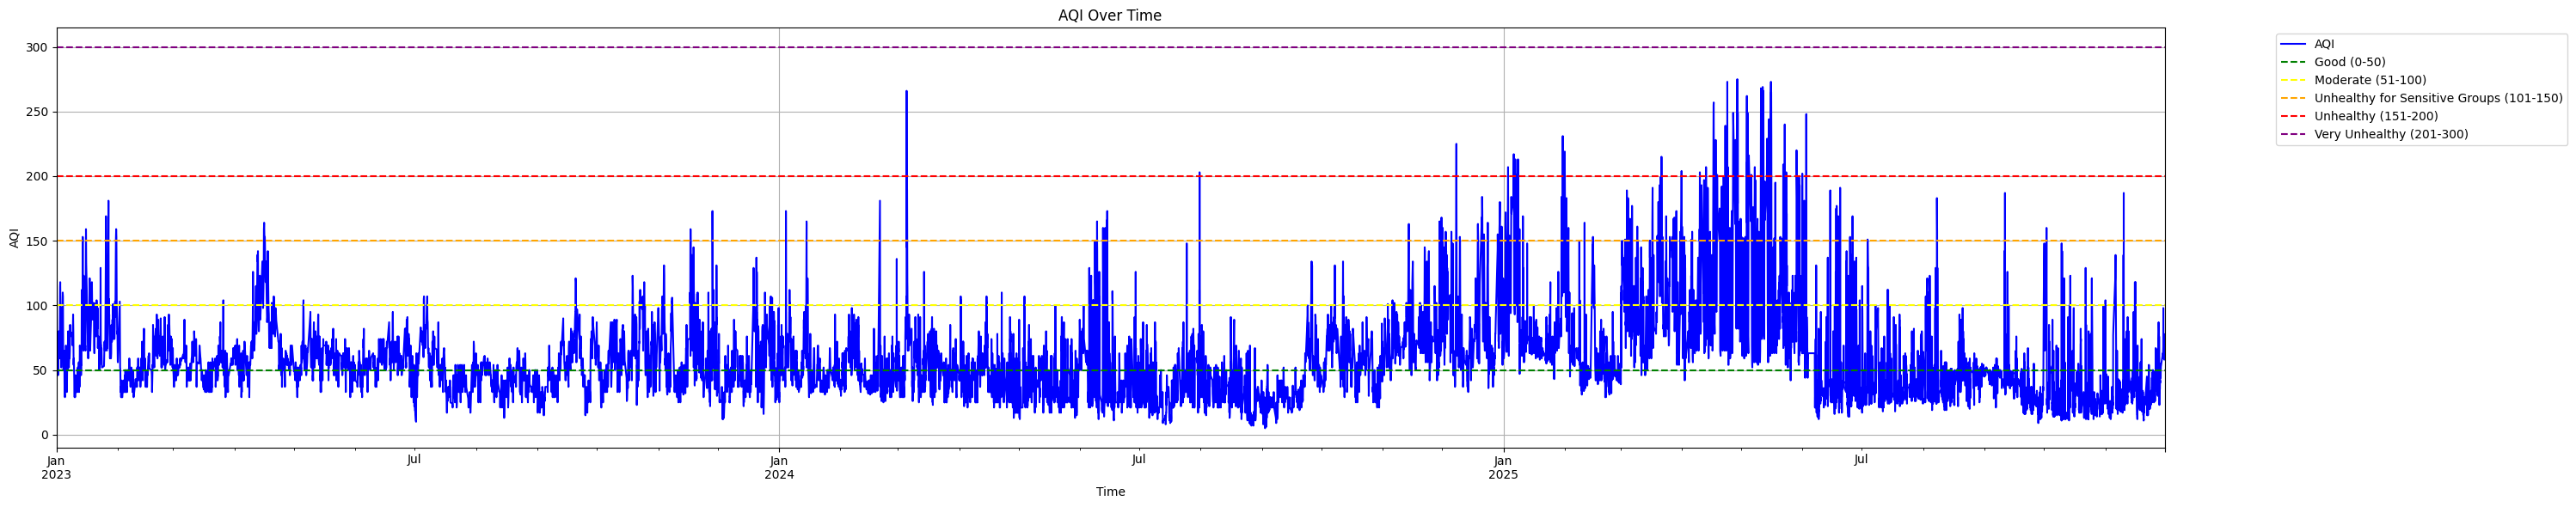

AQI đạt mức cao nhất là  275.0 vào tại thời điểm 2025-04-29 02:00:00


In [10]:
# Biểu đồ đường AQI theo thời gian
plt.figure(figsize=(30, 6))
df_merged["aqi"].plot(kind='line', color='blue', label='AQI')

# Thêm tiêu đề và nhãn trục
plt.title('AQI Over Time')
plt.xlabel('Time')
plt.ylabel('AQI')

# Thêm mức AQI tiêu chuẩn
plt.axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
plt.axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
plt.axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
plt.axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')
plt.axhline(y=300, color='purple', linestyle='--', label='Very Unhealthy (201-300)')


# Hiển thị chú thích
# đẩy chú thích ra ngoài biểu đồ
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị lưới
plt.grid(True)
plt.tight_layout()
plt.show()

# Tìm thời điểm AQI cao nhất
max_aqi_time = df_merged['aqi'].idxmax()
max_aqi_value = df_merged['aqi'].max()
print(f'AQI đạt mức cao nhất là  {max_aqi_value} vào tại thời điểm {max_aqi_time}')

Dựa trên kết quả phân tích chuỗi dữ liệu thời gian từ ngày 01/01/2023 đến 01/12/2025, bức tranh toàn cảnh về hiện trạng môi trường không khí tại TP. Cần Thơ được khắc họa qua ba đặc điểm chính:

**Thứ nhất, về xu hướng nền (Baseline Trend):** Chỉ số AQI tại Cần Thơ thiết lập một mặt bằng dao động phổ biến trong biên độ từ 50 đến 150. Điều này cho thấy chất lượng không khí phần lớn thời gian nằm ở mức Trung bình (Moderate) đến Không tốt cho nhóm nhạy cảm. Biểu đồ cho thấy tần suất xuất hiện của các dải màu xanh (Mức Tốt: 0-50) là rất thưa thớt và không có tính liên tục, phản ánh áp lực thường trực của các tác nhân ô nhiễm lên bầu khí quyển thành phố.

**Thứ hai, về tính chu kỳ (Seasonality):** Dữ liệu khẳng định rõ quy luật biến thiên theo mùa. Các đợt ô nhiễm nghiêm trọng có xu hướng tập trung và bùng phát mạnh vào giai đoạn mùa khô, kéo dài từ tháng 11 năm trước đến giữa tháng 2 năm sau. Trong khung thời gian này, đường biểu diễn AQI thường xuyên vượt qua ngưỡng 150 (Unhealthy), trùng khớp với các điều kiện khí tượng bất lợi hạn chế khả năng khuếch tán khí thải.

**Thứ ba, về các giá trị cực đoan (Outliers):** Nghiên cứu ghi nhận sự xuất hiện của các sự kiện ô nhiễm đột biến vượt xa ngưỡng trung bình. Điểm dị biệt đáng chú ý nhất trong toàn bộ chu kỳ quan trắc được xác định vào lúc 02:00 ngày 29/04/2025, khi chỉ số AQI vọt lên mức xấp xỉ 275, chạm ngưỡng Rất không tốt (Very Unhealthy). Sự kiện này là minh chứng rõ nét cho thấy Cần Thơ hoàn toàn có khả năng đối mặt với các kịch bản ô nhiễm nguy hại.

**Tổng kết lại:** Giai đoạn 2023 – 2025 cho thấy chất lượng không khí tại Cần Thơ không chỉ dừng lại ở mức độ cảnh báo trung bình mà đang đối mặt với các đợt ô nhiễm mang tính quy luật và cường độ cao. Đây là cơ sở thực tiễn quan trọng khẳng định tính cấp thiết của việc xây dựng mô hình dự báo chất lượng không khí nhằm giảm thiểu rủi ro sức khỏe cho cộng đồng.

### 2. Mức độ AQI của các tháng cao đạt cao điểm

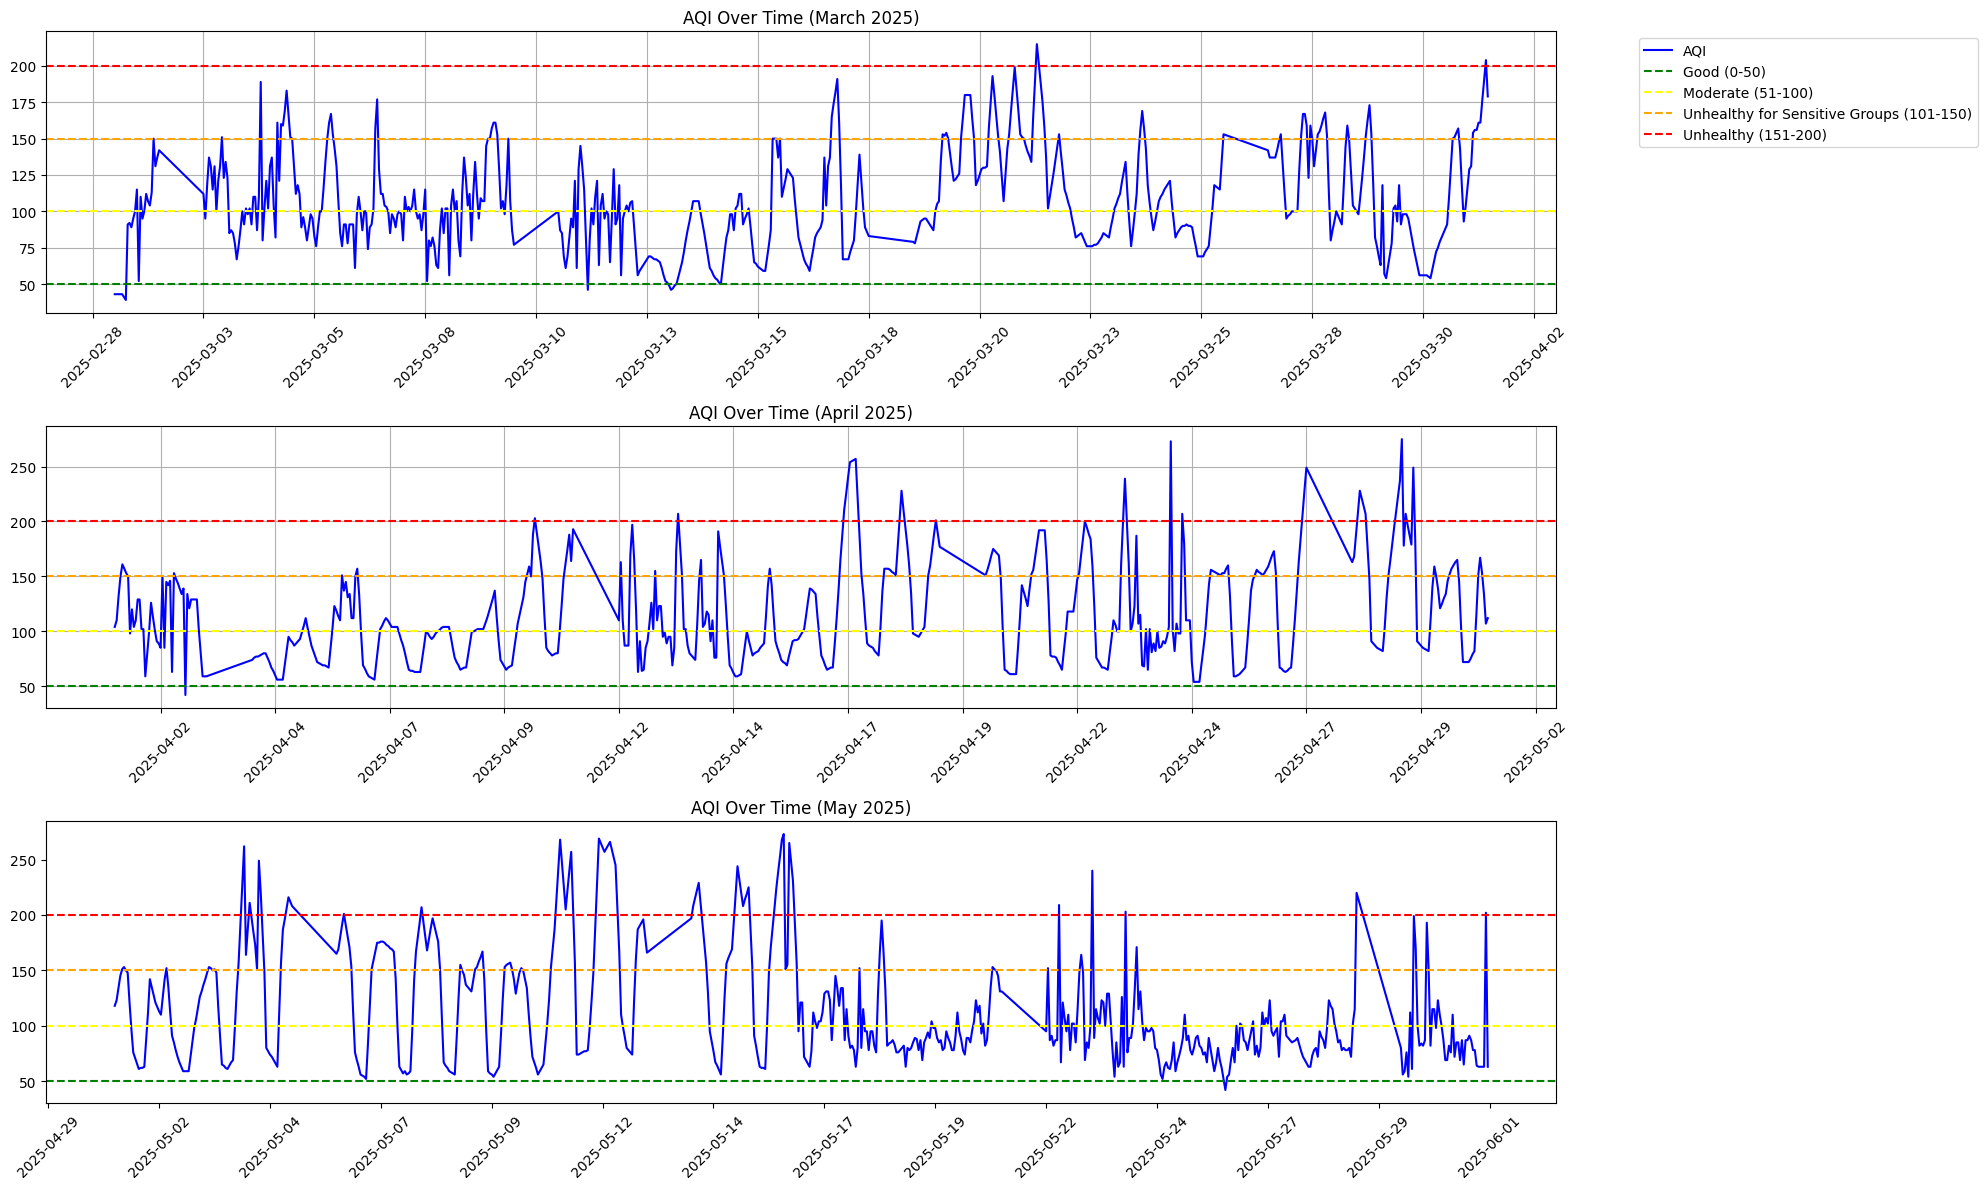

In [11]:
# Tạo biểu đồ kết hợp
fig, axo = plt.subplots(3,1, figsize =(20,12))

# Biểu đồ đường AQI tháng 3/2025 --- IGNORE ---
axo[0].plot(df_merged["2025-03-01":"2025-03-31"]["aqi"], color='blue', label='AQI')
axo[0].set_title('AQI Over Time (March 2025)')
axo[0].grid(True)
axo[0].axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
axo[0].axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
axo[0].axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
axo[0].axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')
axo[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Biểu đồ đường AQI tháng 4/2025
axo[1].plot(df_merged["2025-04-01":"2025-04-30"]["aqi"], color='blue', label='AQI')
axo[1].set_title('AQI Over Time (April 2025)')
axo[1].grid(True)
axo[1].axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
axo[1].axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
axo[1].axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
axo[1].axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')


# Biểu đồ đường AQI tháng 5/2025
axo[2].plot(df_merged["2025-05-01":"2025-05-31"]["aqi"], color='blue', label='AQI')
axo[2].set_title('AQI Over Time (May 2025)')
axo[2].axhline(y=50, color='green', linestyle='--', label='Good (0-50)')
axo[2].axhline(y=100, color='yellow', linestyle='--', label='Moderate (51-100)')
axo[2].axhline(y=150, color='orange', linestyle='--', label='Unhealthy for Sensitive Groups (101-150)')
axo[2].axhline(y=200, color='red', linestyle='--', label='Unhealthy (151-200)')



# Đặt x chỉ hiện thị 15 mốc
for ax in axo:
    ax.xaxis.set_major_locator(plt.MaxNLocator(15))

# Xoay nhãn trục x để dễ đọc
for ax in axo:
    ax.tick_params(axis='x', rotation=45)


# Hiển thị Biểu đồ
plt.tight_layout()
plt.show()

1. **Ý nghĩa của dữ liệu:** Ba tháng 3, 4, 5 được xem là "điểm nóng" ô nhiễm không khí tại Cần Thơ vì đây là giai đoạn giao thoa giữa đỉnh điểm mùa khô và hoạt động nông nghiệp lớn nhất trong năm.

    - Chỉ số AQI cao và biến động mạnh: Biểu đồ tháng 5 cho thấy các cột AQI trồi sụt liên tục với biên độ lớn (từ mức trung bình vọt lên tím/đỏ). Điều này phản ánh nguồn thải không phải là hằng số (như xe cộ) mà là nguồn thải mang tính thời điểm, bùng phát theo từng đợt (tương ứng với các đợt đốt đồng sau thu hoạch).

    - Tính quy luật: Sự gia tăng ô nhiễm trong các tháng này là hệ quả tất yếu của mô hình canh tác lúa tại Đồng bằng sông Cửu Long (ĐBSCL), lặp lại hàng năm nếu không có biện pháp can thiệp.

2. **Nguyên nhân cốt lõi (Tổng hợp từ báo chí và báo cáo khoa học):**

    - Thủ phạm chính: Đốt rơm rạ vụ Đông Xuân Theo báo cáo của Clean Air Asia và các nghiên cứu tại ĐBSCL, tháng 3 và tháng 4 là thời điểm thu hoạch rộ của vụ lúa Đông Xuân – vụ lúa quan trọng và có sản lượng lớn nhất năm.

    - Do áp lực thời vụ để chuẩn bị đất kịp thời cho vụ Hè Thu (xuống giống vào đầu mùa mưa tháng 5), nông dân có thói quen đốt đồng (đốt rơm rạ) ngay tại ruộng để giải phóng đất nhanh chóng.

    - Thống kê cho thấy tỷ lệ đốt rơm rạ trong vụ Đông Xuân lên tới 84%, cao nhất trong năm. Khói bụi từ hàng ngàn hecta ruộng lúa xung quanh Cần Thơ (và từ các tỉnh lân cận như Hậu Giang, An Giang) theo gió phát tán vào nội đô, khiến nồng độ bụi mịn PM2.5 tăng đột biến.

    - Yếu tố cộng hưởng: Thời tiết mùa khô Giai đoạn tháng 3, 4 là cao điểm nắng nóng và khô hạn tại Nam Bộ.

    - Thiếu mưa: Lượng mưa cực thấp trong các tháng này (mùa mưa thường chỉ bắt đầu từ giữa tháng 5) khiến không khí không được "rửa trôi" tự nhiên.

    - Nghịch nhiệt : Điều kiện thời tiết hanh khô ban ngày và nhiệt độ giảm vào ban đêm dễ tạo ra các lớp nghịch nhiệt, nhốt khói bụi do đốt đồng ở tầng thấp sát mặt đất, làm chỉ số AQI duy trì ở mức nguy hại trong nhiều giờ liền.

Kết luận: Đỉnh điểm ô nhiễm tháng 3, 4, 5 tại Cần Thơ không phải do ngẫu nhiên mà là hệ quả của bài toán "Mùa vụ nông nghiệp + Khắc nghiệt khí hậu". Để cải thiện, mấu chốt nằm ở việc kiểm soát hoạt động đốt rơm rạ tự phát tại các huyện ngoại thành. Thông tin vào [Cảnh báo nguy cơ tai nạn giao thông từ khói bụi đốt rơm rạ | VTV CẦN THƠ](https://youtube.com/shorts/I_Td-WjX5Rg?si=-Qv3XfhcjH0RkHfS)

## Phân tích mức PM2.5

### 1. Phân bố mức độ PM 2.5 trong suốt 1/1/2023 đến 1/12/2025

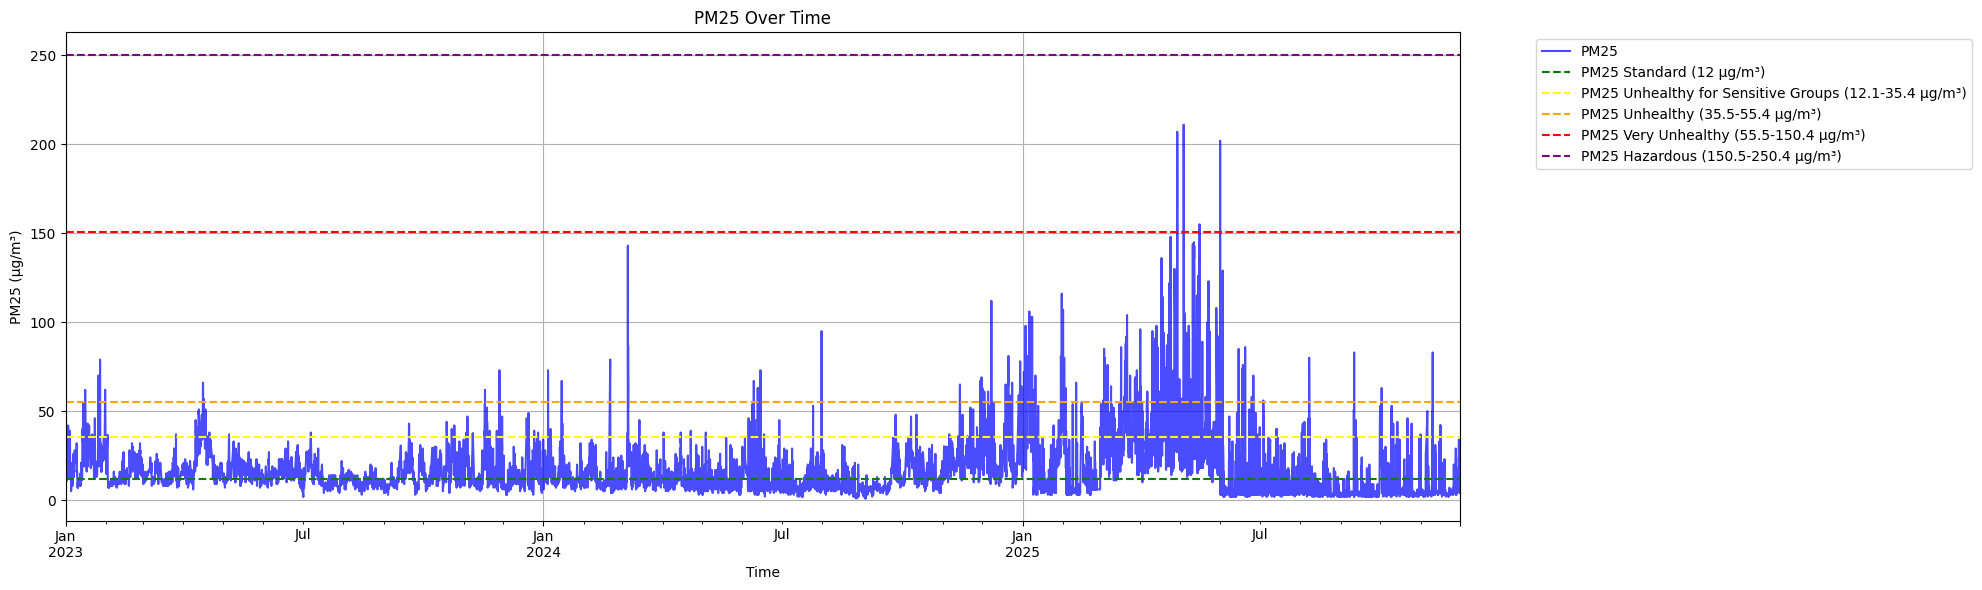

In [12]:
plt.figure(figsize=(20, 6))
df_merged["pm25"].plot(kind='line', color='blue', label='PM25', alpha=0.7)

# Thêm tiêu đề và nhãn trục
plt.title('PM25 Over Time')
plt.xlabel('Time')
plt.ylabel('PM25 (µg/m³)')

# Thêm mức PM25 tiêu chuẩn
plt.axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
plt.axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')
plt.axhline(y=55.4, color='orange', linestyle='--', label='PM25 Unhealthy (35.5-55.4 µg/m³)')
plt.axhline(y=150.4, color='red', linestyle='--', label='PM25 Very Unhealthy (55.5-150.4 µg/m³)')
plt.axhline(y=250.4, color='purple', linestyle='--', label='PM25 Hazardous (150.5-250.4 µg/m³)')


# Hiển thị chú thích
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.grid(True)
plt.tight_layout()
plt.show()

**TP. Cần Thơ có nền không khí tương đối sạch, nhưng tồn tại những đợt ô nhiễm bụi cực đoan đáng báo động.**

Cụ thể:
1. Mức nền an toàn: Giá trị trung bình ($Mean$) chỉ khoảng 16.56 $\mu g/m^3$ và $75\%$ thời gian nồng độ bụi nằm dưới mức 20.67 $\mu g/m^3$. Điều này cho thấy trong điều kiện bình thường, không khí Cần Thơ nằm trong ngưỡng an toàn theo quy chuẩn Việt Nam (QCVN 05:2013/BTNMT quy định trung bình 24h là 50 $\mu g/m^3$).

2. Sự biến động cực lớn: Độ lệch chuẩn ($Std$) xấp xỉ giá trị trung bình (~15.55) và giá trị cực đại ($Max$) vọt lên tới 211.0 $\mu g/m^3$ (gấp 4 lần ngưỡng cho phép). Điều này khẳng định ô nhiễm tại Cần Thơ không diễn ra liên miên mà mang tính "bùng phát"  – tức là bình thường thì rất sạch, nhưng khi ô nhiễm thì cực kỳ nghiêm trọng (thường liên quan đến các sự kiện đốt rơm rạ hoặc nghịch nhiệt).

###  2. Các phân bố cao điểm đối với từng giờ của PM 2.5

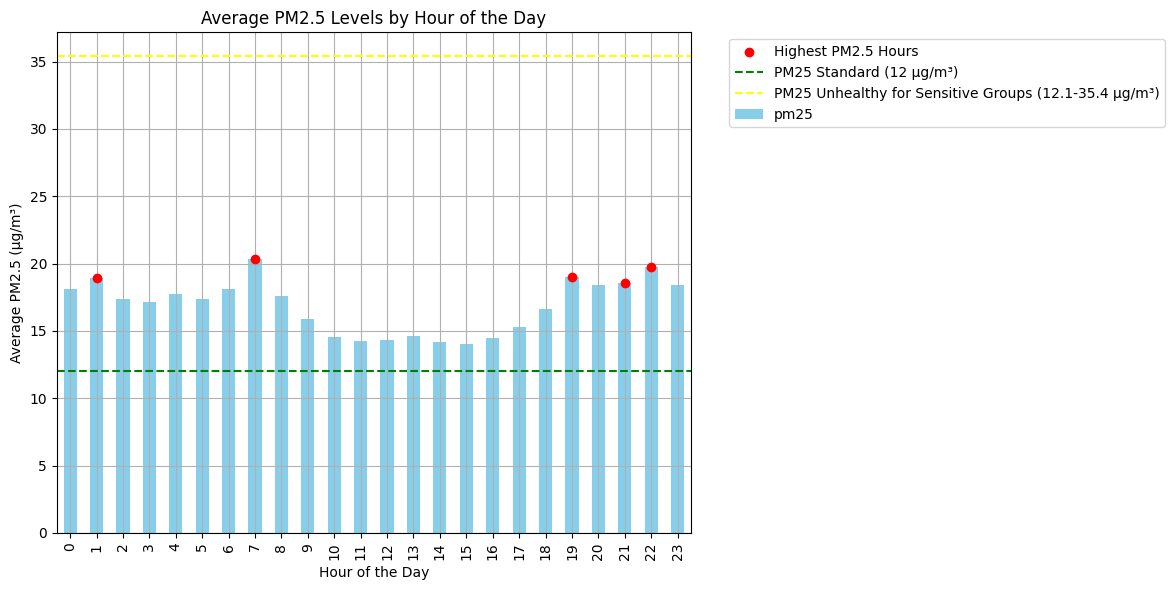

Giờ có mức PM2.5 trung bình cao nhất trong ngày:
7     20.322784
22    19.720860
19    19.003408
1     18.928922
21    18.579431
Name: pm25, dtype: float64


In [13]:
# dữ liệu PM2.5 theo giờ trong ngày và tính giá trị trung bình
hourly_pm25 = df_merged['pm25'].groupby(df_merged.index.hour).mean()

# Tìm giờ có mức PM2.5 trung bình cao nhất
number_of_hours = 5
highest_pm25_hour = hourly_pm25.nlargest(number_of_hours)

# Biểu đồ thanh mức PM2.5 trung bình theo giờ trong ngày
plt.figure(figsize=(12,6))
hourly_pm25.plot(kind='bar', color='skyblue')

# Đánh dấu các giờ có mức PM2.5 cao nhất
plt.scatter(highest_pm25_hour.index, highest_pm25_hour.values, color='red', zorder=number_of_hours, label='Highest PM2.5 Hours')

# Hiện tiêu chuẩn PM2.5
plt.axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
plt.axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')

# Thêm tiêu đề và nhãn trục
plt.title('Average PM2.5 Levels by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average PM2.5 (µg/m³)')

# Hiển thị chú thích
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.grid(True)
plt.tight_layout()
plt.show()

# Hiện thị giá trị giờ có mức PM2.5 cao nhất
print("Giờ có mức PM2.5 trung bình cao nhất trong ngày:")
print(highest_pm25_hour)

**Phân tích chuỗi dữ liệu theo giờ cho thấy một nghịch lý thú vị:** Các khung giờ cao điểm giao thông buổi chiều (17h-18h) không ghi nhận nồng độ $PM_{2.5}$ cao nhất. Thay vào đó, ô nhiễm đạt cực đại vào lúc 7:00 sáng ($20.32 \mu g/m^3$) và duy trì ở mức cao vào ban đêm (19:00 - 22:00 và 01:00 sáng).Điều này cho thấy cơ chế khuếch tán khí quyển đóng vai trò chủ đạo. Vào lúc 7:00 sáng, sự gia tăng phát thải từ phương tiện giao thông cộng hưởng với hiện tượng nghịch nhiệt sáng sớm đã đẩy nồng độ bụi lên cao nhất. Ngược lại, vào ban đêm, sự sụt giảm độ cao của lớp biên khí quyển (Planetary Boundary Layer) kết hợp với độ ẩm cao đặc thù của vùng sông nước Cần Thơ đã ngăn cản quá trình phát tán bụi, dẫn đến sự tích tụ ô nhiễm kéo dài ngay cả khi hoạt động con người đã giảm thiểu.

### 3. Phân bố PM 2.5 theo mùa

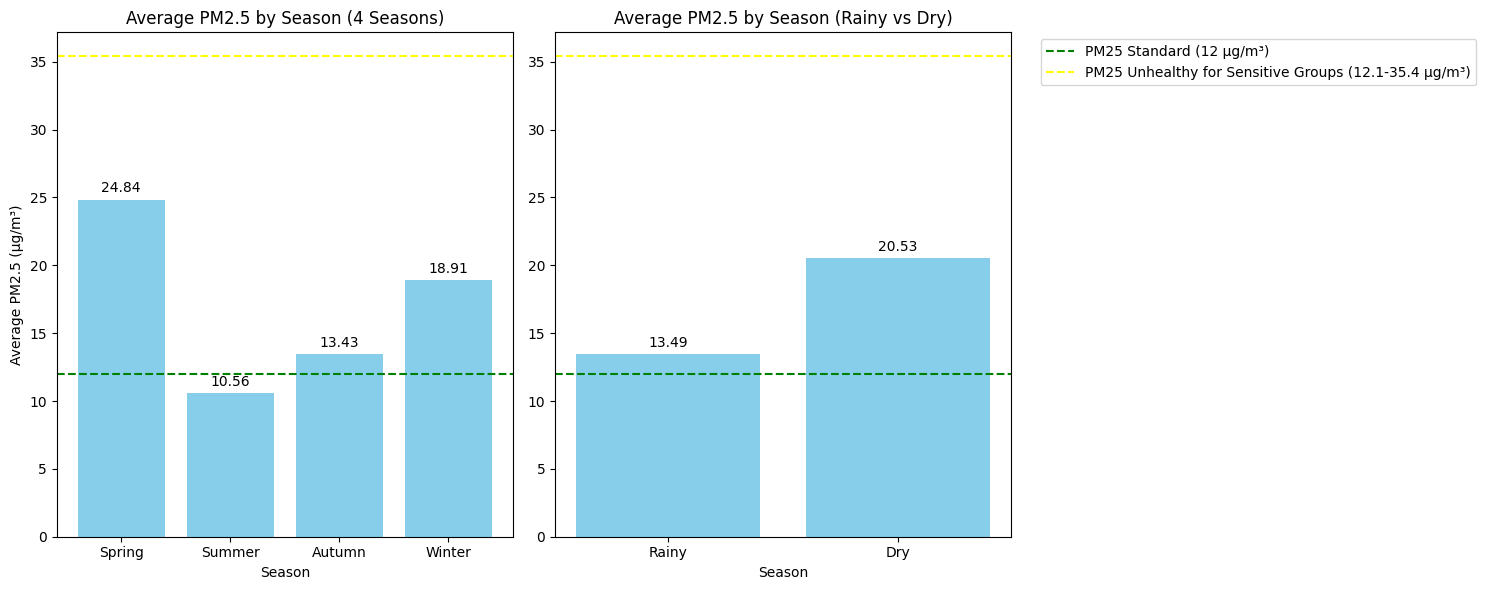

In [14]:
# Đinh nghĩa các mùa trong năm  - 4 mùa trong năm
seasons = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

# Định nghĩa  mùa khô và mua mưa 
seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

# Gộp dữ liệu theo mùa và tính giá trị trung bình AQI - 4 mùa trong năm 
seasonal_4_pm25 = {}
seasonal_rain_dry_pm25 = {}
for season, months in seasons.items():
    seasonal_4_pm25[season] = df_merged.loc[df_merged.index.month.isin(months), 'pm25'].mean()

# Gộp dữ liệu theo mùa và tính giá trị trung bình AQI - mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    seasonal_rain_dry_pm25[season] = df_merged.loc[df_merged.index.month.isin(months), 'pm25'].mean()

# Tạo biểu đồ thanh cho cả hai phân loại mùa
fig, axo = plt.subplots(1,2, figsize =(15,6))
# Biểu đồ thanh PM2.5 theo 4 mùa trong năm
bars1 = axo[0].bar(seasonal_4_pm25.keys(), seasonal_4_pm25.values(), color='skyblue')

# Thêm tiêu đề và nhãn trục
axo[0].set_title('Average PM2.5 by Season (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Average PM2.5 (µg/m³)')

# Thêm mức PM2.5 tiêu chuẩn
axo[0].axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
axo[0].axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')

# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh PM2.5 theo mùa mưa và mùa khô
bars2 = axo[1].bar(seasonal_rain_dry_pm25.keys(), seasonal_rain_dry_pm25.values(), color='skyblue')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Average PM2.5 by Season (Rainy vs Dry)')
axo[1].set_xlabel('Season')

# Thêm mức PM2.5 tiêu chuẩn
axo[1].axhline(y=12, color='green', linestyle='--', label='PM25 Standard (12 µg/m³)')
axo[1].axhline(y=35.4, color='yellow', linestyle='--', label='PM25 Unhealthy for Sensitive Groups (12.1-35.4 µg/m³)')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

Phân tích phân bố theo mùa cho thấy sự đồng nhất trong quy luật ô nhiễm tại Cần Thơ. Trong mô hình 4 mùa, nồng độ $PM_{2.5}$ đạt đỉnh vào Mùa Xuân (tháng 3-5), trùng khớp với giai đoạn cao điểm của Mùa Khô trong mô hình 2 mùa.Hiện tượng này được giải thích bởi sự cộng hưởng của hai yếu tố:
- *Yếu tố Nhân sinh:* Đây là thời điểm thu hoạch vụ lúa Đông Xuân, dẫn đến hoạt động đốt rơm rạ quy mô lớn, phát tán lượng bụi mịn khổng lồ vào không khí.

- *Yếu tố Khí tượng:* Sự thiếu hụt lượng mưa (cơ chế rửa trôi tự nhiên yếu) kết hợp với hiện tượng nghịch nhiệt trong mùa khô đã ngăn cản sự khuếch tán của chất ô nhiễm. Ngược lại, vào mùa mưa (Mùa Hè/Thu), nồng độ bụi giảm mạnh nhờ hiệu ứng làm sạch của nước mưa và sự đối lưu không khí tốt hơn.

## Phân tích lượng mưa

### Phân bố lượng mưa trong suốt 1/1/2023 đến 1/12/2025

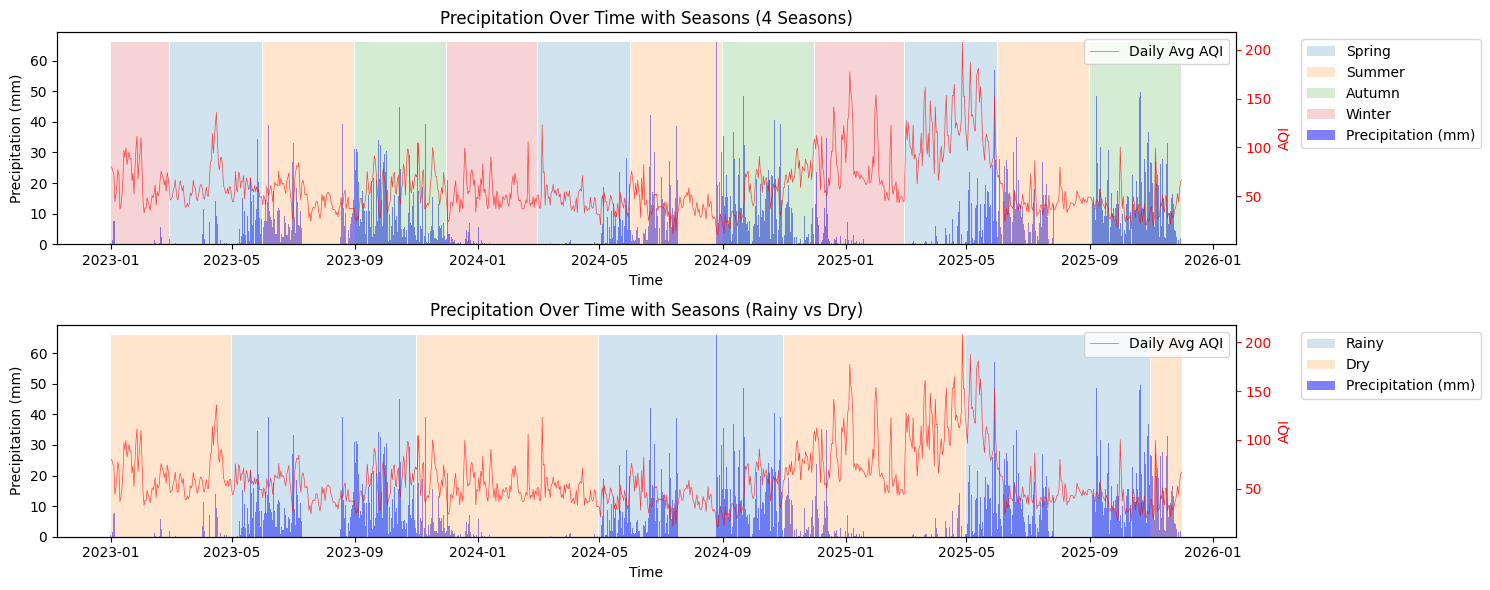

In [29]:
fig, axo = plt.subplots(2,1, figsize =(15,6))

# Định nghĩa mùa 
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}

#tính lượng mưa từng ngày 
df_precip = df_merged['precip'].resample('D').sum()


# Plot cho 4 mùa trong năm
axo[0].bar(df_precip.index, df_precip, color='blue', alpha=0.5, label='Precipitation (mm)')
# Vẽ đường AQI trung bình hàng ngày
df_daily_aqi = df_merged['aqi'].resample('D').mean()

# axo[0]
axo0_aqi = axo[0].twinx()
axo0_aqi.plot(df_daily_aqi.index, df_daily_aqi, color='red', linewidth=0.5, alpha=0.7, label='Daily Avg AQI')
axo0_aqi.set_ylabel('AQI', color='red')
axo0_aqi.tick_params(axis='y', colors='red')
axo0_aqi.legend(loc='upper right')

# axo[1]
axo1_aqi = axo[1].twinx()
axo1_aqi.plot(df_daily_aqi.index, df_daily_aqi, color='red', linewidth=0.5, alpha=0.7, label='Daily Avg AQI')
axo1_aqi.set_ylabel('AQI', color='red')
axo1_aqi.tick_params(axis='y', colors='red')
axo1_aqi.legend(loc='upper right')
# Điền màu cho các mùa
for season, months in seasons4.items():
    axo[0].fill_between(df_precip.index, 0, df_precip.max(),
                     where=df_precip.index.month.isin(months), 
                     alpha=0.2, label=season)

# Thêm tiêu đề và nhãn trục
axo[0].set_title("Precipitation Over Time with Seasons (4 Seasons)")
axo[0].set_xlabel('Time')
axo[0].set_ylabel('Precipitation (mm)')


axo[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot cho mùa mưa và mùa khô
axo[1].bar(df_precip.index, df_precip, color='blue', alpha=0.5, label='Precipitation (mm)')

# Điền màu cho mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    axo[1].fill_between(df_precip.index, 0, df_precip.max(),
                     where=df_precip.index.month.isin(months),
                     alpha=0.2, label=season)

# Thêm tiêu đề và nhãn trục
axo[1].set_title('Precipitation Over Time with Seasons (Rainy vs Dry)')
axo[1].set_xlabel('Time')
axo[1].set_ylabel('Precipitation (mm)')
axo[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()


### Tổng lượng mưa của từng năm

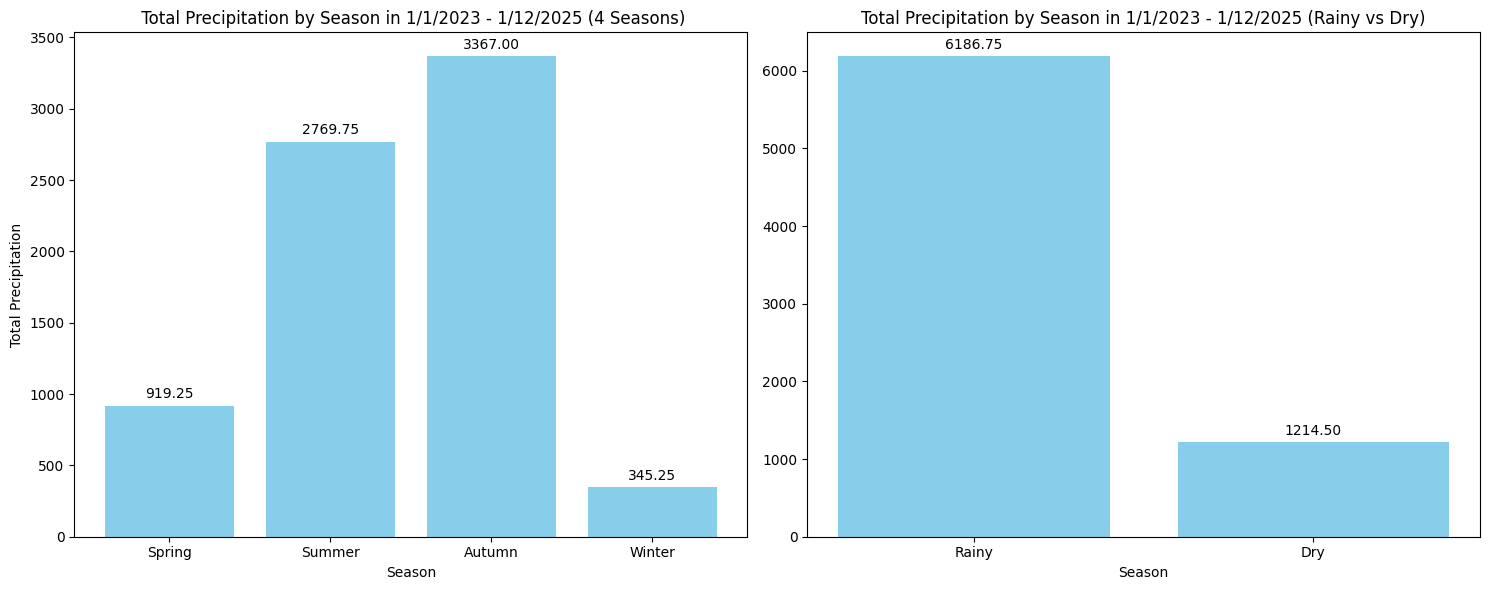

In [32]:
# Định nghĩa mùa 
seasons4 = {
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11],
    'Winter': [12, 1, 2]
}

seasons_rain_dry = {
    'Rainy': [5, 6, 7, 8, 9, 10],
    'Dry': [11, 12, 1, 2, 3, 4]
}
# Tính lượng mưa trung bình theo mùa
seasonal_4_precip = {}
seasonal_rain_dry_precip = {}

## Tính lượng mưa trung bình theo mùa - 4 mùa trong năm
for season, months in seasons4.items():
    seasonal_4_precip[season] = df_precip[df_precip.index.month.isin(months)].sum()
## Tính lượng mưa trung bình theo mùa - mùa mưa và mùa khô
for season, months in seasons_rain_dry.items():
    seasonal_rain_dry_precip[season] = df_precip[df_precip.index.month.isin(months)].sum()

# Tạo biểu đồ thanh cho cả hai phân loại mùa
fig, axo = plt.subplots(1,2, figsize =(15,6))
# Biểu đồ thanh lượng mưa theo 4 mùa trong năm
bars1 = axo[0].bar(seasonal_4_precip.keys(), seasonal_4_precip.values(), color='skyblue')
# Thêm tiêu đề và nhãn trục
axo[0].set_title(' Total Precipitation by Season in 1/1/2023 - 1/12/2025 (4 Seasons)')
axo[0].set_xlabel('Season')
axo[0].set_ylabel('Total Precipitation')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars1:
    height = bar.get_height()
    axo[0].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Biểu đồ thanh lượng mưa theo mùa mưa và mùa khô
bars2 = axo[1].bar(seasonal_rain_dry_precip.keys(), seasonal_rain_dry_precip.values(), color='skyblue')
# Thêm tiêu đề và nhãn trục
axo[1].set_title('Total Precipitation by Season in 1/1/2023 - 1/12/2025 (Rainy vs Dry)')
axo[1].set_xlabel('Season')
# Thêm nhãn giá trị lên trên mỗi thanh
for bar in bars2:
    height = bar.get_height()
    axo[1].annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# Hiện thị biểu đồ
plt.tight_layout()
plt.show()

Trong giai đoạn từ 2023 đến 2025, Cần Thơ ghi nhận sự biến động mạnh về chế độ thủy văn. Khi phân tích biểu đồ tổng hợp lượng mưa theo mùa, có thể thấy rõ Mùa Hè và Mùa Thu là hai giai đoạn nhận được lượng mưa dồi dào nhất; trong đó, Mùa Thu chiếm tỷ trọng áp đảo với tổng lượng mưa đạt mức kỷ lục 3367.00 mm. Ngược lại, Mùa Đông được ghi nhận là thời điểm khô hạn nhất trong năm khi lượng mưa giảm sâu, chỉ còn 345.25 mm.

Sự phân hóa này dẫn đến một sự chênh lệch lớn giữa tổng lượng mưa Mùa Mưa (6186.75 mm) và Mùa Khô (1214.50 mm). Quan sát biểu đồ diễn biến theo thời gian, sự khan hiếm mưa trong mùa khô và các tháng mùa Đông có mối tương quan trực tiếp đến sự gia tăng của các đỉnh ô nhiễm không khí . Trong khi đó, lượng mưa lớn và liên tục vào Mùa Thu đóng vai trò then chốt trong việc rửa trôi bụi mịn, giúp duy trì chất lượng không khí ở mức ổn định.


## Phân tích áp suất